In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# 禁用科学计数法 (可能会影响结果)
#pd.set_option('display.float_format',lambda x : '%.2f' % x)

#设置最多显示的行
pd.set_option('display.max_rows',500) 
#设置最多显示的列
pd.set_option('display.max_columns',100)
#对matplotlib进行设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.style.use('fivethirtyeight')

#解决负号显示不了的问题
plt.rcParams['axes.unicode_minus']=False


In [2]:
train = pd.read_csv('C:/Users/Administrator/input/train_new_use.csv')
test = pd.read_csv('C:/Users/Administrator/input/test_new_use.csv')
work_sd = pd.read_csv('C:/Users/Administrator/input/work_sd.csv')
test_work_sd = pd.read_csv('C:/Users/Administrator/input/test_work_sd.csv')
train_features_new = pd.read_csv('C:/Users/Administrator/input/train_features_new.csv')
test_features_new = pd.read_csv('C:/Users/Administrator/input/test_features_new.csv')

In [3]:
train.head()

,渔船ID,X,Y,速度,方向,time,type,dX,dY,加速度,方向变化,month,day,hour
0,0,6.152038e+06,5.124873e+06,2.59,102,1900-11-10 11:58:19,拖网,808.914660,-344.632139,-0.11,-11,11,10,11
1,0,6.151230e+06,5.125218e+06,2.70,113,1900-11-10 11:48:19,拖网,808.872353,-344.699932,0.00,-3,11,10,11
2,0,6.150421e+06,5.125563e+06,2.70,116,1900-11-10 11:38:19,拖网,808.830024,-344.767718,-0.59,21,11,10,11
3,0,6.149612e+06,5.125907e+06,3.29,95,1900-11-10 11:28:19,拖网,808.787673,-344.835498,0.11,-13,11,10,11
4,0,6.148803e+06,5.126252e+06,3.18,108,1900-11-10 11:18:19,拖网,805.325842,-562.955816,0.21,-21,11,10,11


In [4]:
def get_data(path,get_type=True):
    features = []
 
    if get_type:
        for name,df in tqdm(train.groupby('渔船ID')):
            file = name
            
            df['time']=pd.to_datetime(df['time'])
            t_diff=df['time'].diff().iloc[1:].dt.total_seconds()
            x_diff=df['X'].diff().iloc[1:].abs()
            y_diff=df['Y'].diff().iloc[1:].abs()
            dis=sum(np.sqrt(x_diff**2+y_diff**2))
            x_a_mean=(x_diff/t_diff).mean()
            y_a_mean=(y_diff/t_diff).mean()
            
            features.append([df['X'].std(), df['X'].mean(),df['X'].max(),df['X'].min(),df['X'].median(),
                             df['Y'].std(), df['Y'].mean(),df['Y'].max(),df['Y'].min(),df['Y'].median(),
                             df['速度'].std(), df['速度'].mean(), df['速度'].max(),df['速度'].min(),df['速度'].median(),
                             df['方向'].std(), df['方向'].mean(),df['方向'].max(),df['方向'].min(),df['方向'].median(),
                             df['Y'].max() - df['X'].min(),df['X'].max() - df['Y'].min(),df['速度'].skew(),
                             df['X'].max() - df['X'].min(),df['Y'].max() - df['Y'].min(),
                             np.sqrt(x_a_mean**2+y_a_mean**2),df['X'].cov(df['Y']),
                             file,
                             df['type'].iloc[0]])
        df = pd.DataFrame(features)
        df = df.rename(columns={0:'X_std',1:'X_mean',2:'X_max',3:'X_min',4:'X_median',
                               5:'Y_std',6:'Y_mean',7:'Y_max',8:'Y_min',9:'Y_median',
                                10:'sd_std',11:'sd_mean',12:'sd_max',13:'sd_min',14:'sd_median',
                                15:'fx_std',16:'fx_mean',17:'fx_max',18:'fx_min',19:'fx_median',
                                20:'Y_max_X_min',21:'X_max_Y_min',22:'sd_skew',
                                23:'X_max_X_min',24:'Y_max_Y_min',
                                25:'a',26:'xy_cov'
                                   
                               
                               })
        df = df.rename(columns={len(features[0])-2:'filename',len(features[0])-1:'label'})
        label_dict = {'拖网':0, '刺网':1, '围网':2}
        df['label'] = df['label'].map(label_dict)
        return df
    else:
        for name,df in tqdm(test.groupby('渔船ID')):
            file = name
            
            df['time']=pd.to_datetime(df['time'])
            t_diff=df['time'].diff().iloc[1:].dt.total_seconds()
            x_diff=df['X'].diff().iloc[1:].abs()
            y_diff=df['Y'].diff().iloc[1:].abs()
            dis=sum(np.sqrt(x_diff**2+y_diff**2))
            x_a_mean=(x_diff/t_diff).mean()
            y_a_mean=(y_diff/t_diff).mean()
            
            features.append([df['X'].std(), df['X'].mean(),df['X'].max(),df['X'].min(),df['X'].median(),
                             df['Y'].std(), df['Y'].mean(),df['Y'].max(),df['Y'].min(),df['Y'].median(),
                             df['速度'].std(), df['速度'].mean(), df['速度'].max(),df['速度'].min(),df['速度'].median(),
                             df['方向'].std(), df['方向'].mean(),df['方向'].max(),df['方向'].min(),df['方向'].median(),
                             df['Y'].max() - df['X'].min(),df['X'].max() - df['Y'].min(),df['速度'].skew(),
                             df['X'].max() - df['X'].min(),df['Y'].max() - df['Y'].min(),
                             np.sqrt(x_a_mean**2+y_a_mean**2),df['X'].cov(df['Y']),
                             file
                             ])
        df = pd.DataFrame(features)
        df = df.rename(columns={0:'X_std',1:'X_mean',2:'X_max',3:'X_min',4:'X_median',
                               5:'Y_std',6:'Y_mean',7:'Y_max',8:'Y_min',9:'Y_median',
                                10:'sd_std',11:'sd_mean',12:'sd_max',13:'sd_min',14:'sd_median',
                                15:'fx_std',16:'fx_mean',17:'fx_max',18:'fx_min',19:'fx_median',
                                20:'Y_max_X_min',21:'X_max_Y_min',22:'sd_skew',
                                23:'X_max_X_min',24:'Y_max_Y_min',
                                25:'a',26:'xy_cov',
                               })
        df = df.rename(columns={len(features[0])-1:'filename'})
        return df



In [5]:
df_train = get_data(train)
df_test = get_data(test, False)



100%|██████████| 2000/2000 [00:16<00:00, 123.73it/s]


In [6]:
work_sd = work_sd.rename(columns={'渔船ID':'filename'})
test_work_sd = test_work_sd.rename(columns = {'渔船ID':'filename'})
train_features_new = train_features_new.rename(columns={'渔船ID':'filename'})
test_features_new = test_features_new.rename(columns={'渔船ID':'filename'})

In [7]:
df_train = pd.merge(df_train,work_sd,on='filename',how='left')
df_train = pd.merge(df_train,train_features_new,on='filename',how='left')


In [8]:
df_test = pd.merge(df_test,test_work_sd,on='filename',how='left')
df_test = pd.merge(df_test,test_features_new,on='filename',how='left')

In [11]:
folds = KFold(n_splits=5, shuffle=True, random_state=8)
oof_lgb = np.zeros((len(df_train),3))
col = [tmp_col for tmp_col in df_train.columns if tmp_col not in ['label', 'filename','sd_min','fx_min','fx_max','fx_median']]
X_train = df_train[col].values
y_train = df_train['label'].values
prediction = np.zeros((len(df_test),3))



In [12]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cab
from sklearn.model_selection import train_test_split

kind = df_train['label']
x_train,x_test,y_train,y_test=train_test_split(X_train,kind,test_size=0.1,random_state=78)

In [13]:
xlf=xgb.XGBClassifier(max_depth=6
                      ,learning_rate=0.39
                      ,n_estimators=150
                      ,reg_alpha=0.004
                      ,n_jobs=-1
                      ,reg_lambda=0.002
                      ,importance_type='total_cover')
xlf.fit(x_train,y_train,sample_weight=kind.map({0:3,1:5.5,2:2.5}))
weight_xgb=f1_score(y_test,xlf.predict(x_test),average='macro')
weight_xgb

0.9225479812292584

In [14]:
clf=cab.CatBoostClassifier(iterations=700
                          ,learning_rate=0.5
                          ,depth=4
                          ,loss_function='MultiClass'
                          ,silent=True
                          ,class_weights=[3,5,2.5]
                          ,gpu_cat_features_storage=-1)
clf.fit(x_train,y_train)
weight_cab=f1_score(y_test,clf.predict(x_test),average='macro')
weight_cab

0.8886030764169432

In [15]:
llf=lgb.LGBMClassifier(num_leaves=15
                       ,max_depth=8
                       ,learning_rate=0.39
                       ,n_estimators=180
                       ,class_weight={0:3,1:5,2:2.5}
                       ,objective='multiclass'
                       ,n_jobs=-1
                       ,reg_alpha=0
                       ,reg_lambda=0)
llf.fit(x_train,y_train)
weight_lgb=f1_score(y_test,llf.predict(x_test),average='macro')
weight_lgb

0.9011752878439601

In [16]:
prob_xgb=xlf.predict_proba(x_test)
prob_lgb=llf.predict_proba(x_test)
prob_cab=clf.predict_proba(x_test)
scores=[]
weight=np.arange(0,1.1,0.1)
for i,item1 in enumerate(weight):#找到一个线性组合使效果达到最大
    for j,item2 in enumerate(weight[weight<=(1-item1)]):
            prob_end=prob_xgb*item1+prob_lgb*item2+prob_cab*(1-item1-item2)
            score=f1_score(y_test,np.argmax(prob_end,axis=1),average='macro')
            scores.append(score)
max(scores)

0.929369515812605

Text(0.5, 1.0, 'xgboost&lightgbm&catboost——feature_importances_')

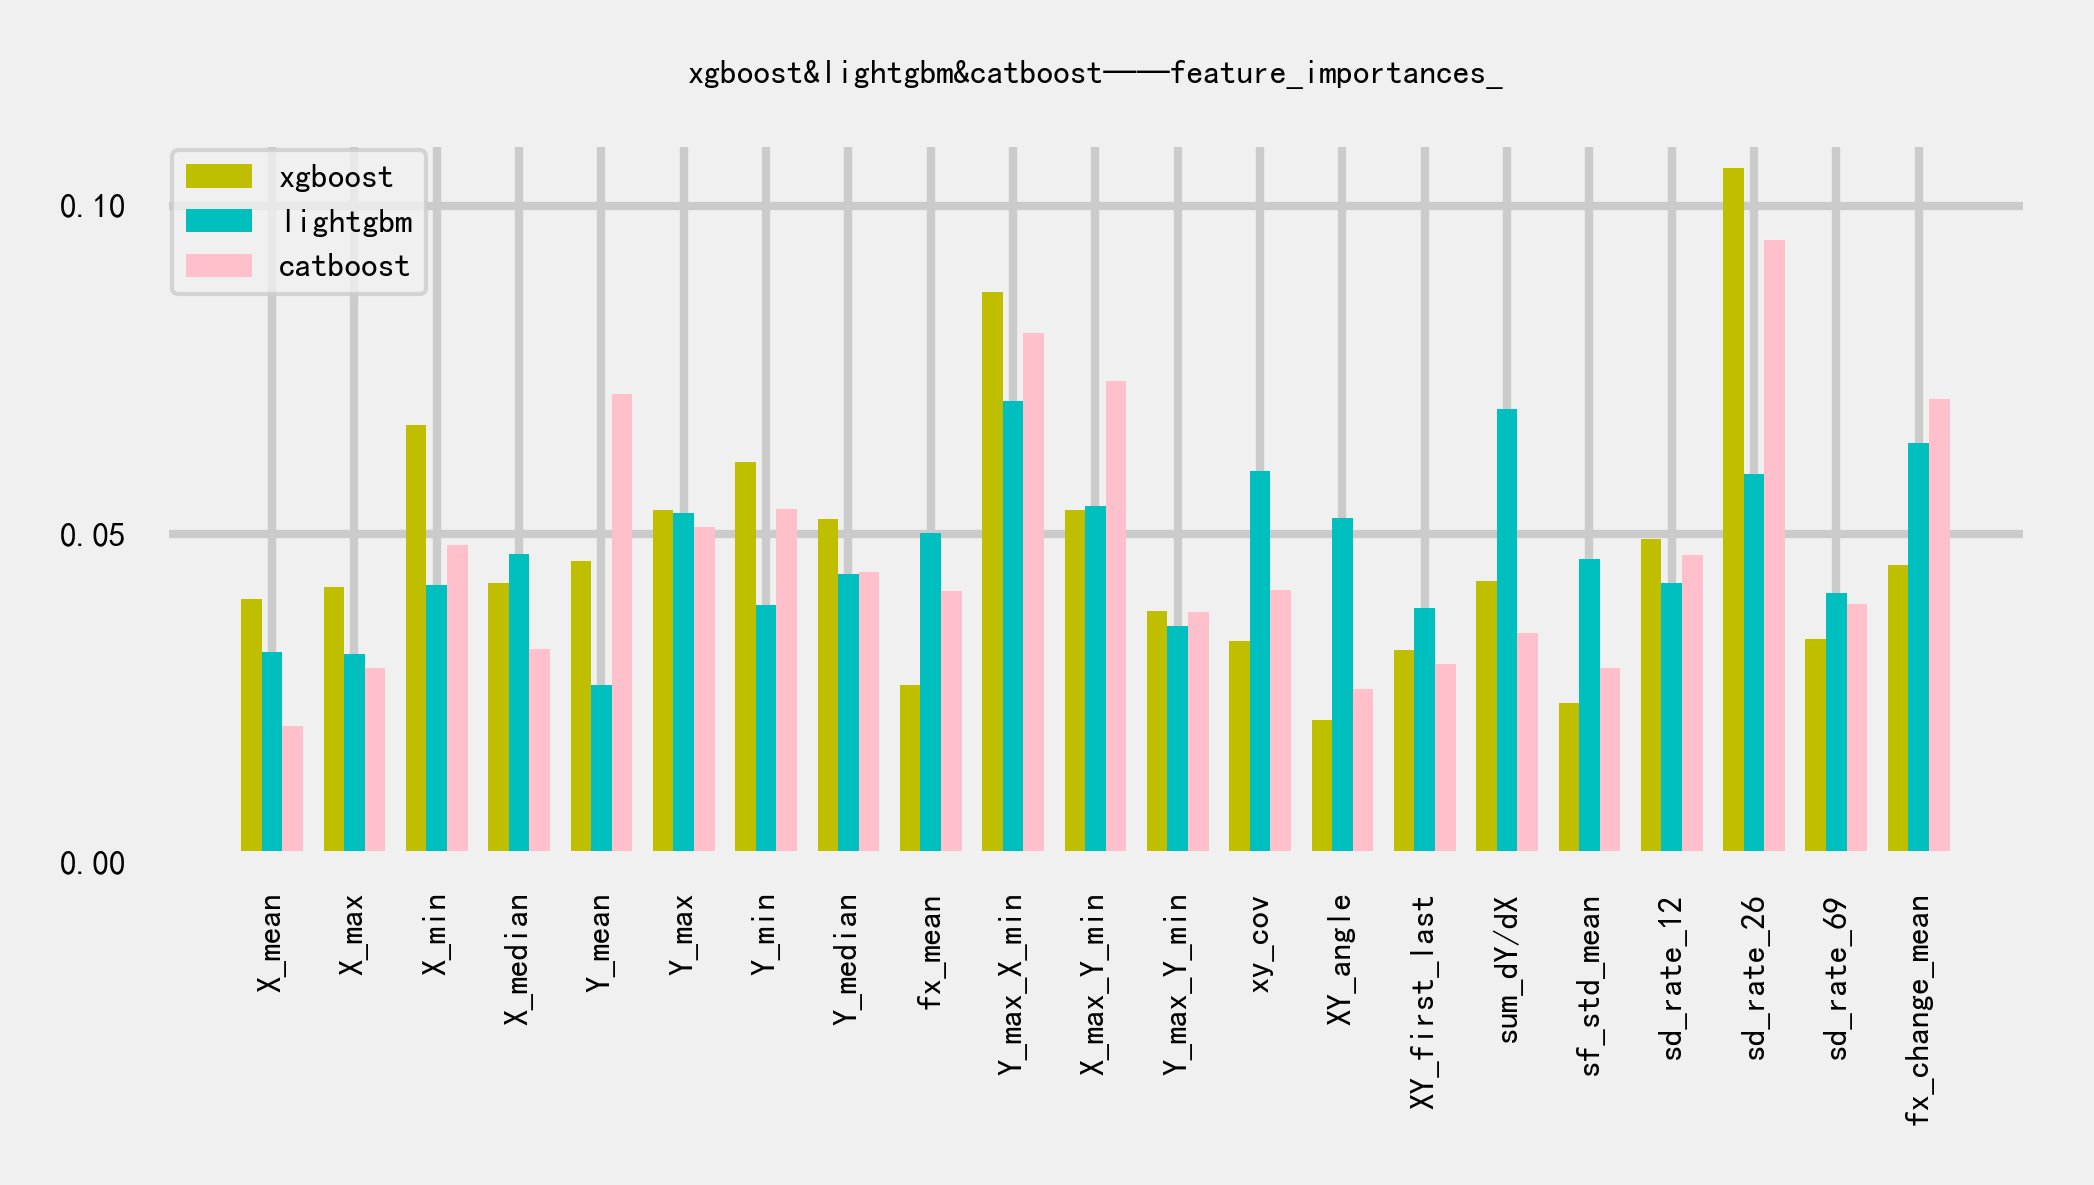

In [41]:
width=0.25
address=np.arange(len(col))
tick_label=col
plt.figure(dpi=600,figsize=(3.6,1.5))
plt.bar(address
        ,xlf.feature_importances_
        ,width
        ,color='y'
        ,label='xgboost')
plt.bar(address+width
        ,llf.feature_importances_/sum(llf.feature_importances_)
        ,width
        ,color='c'
        ,label='lightgbm')
plt.bar(address+2*width
        ,clf.feature_importances_/sum(clf.feature_importances_)
        ,width
        ,color='pink'
        ,label='catboost')
plt.legend(fontsize=4)
plt.xticks(address+width
           ,tick_label
           ,fontsize=4
           ,rotation=90
           ,horizontalalignment='center')
plt.yticks(fontsize=4,rotation=0)
plt.title('xgboost&lightgbm&catboost——feature_importances_',fontsize=4)

In [23]:
test_data = df_test[col]
train_data = df_train[col]

In [24]:
details=[]
answers=[]

from sklearn.model_selection import StratifiedKFold

sk=StratifiedKFold(n_splits=20,shuffle=True,random_state=2020)
for train,test in sk.split(train_data,kind):
    
    x_train=train_data.iloc[train]
    y_train=kind.iloc[train]
    x_test=train_data.iloc[test]
    y_test=kind.iloc[test]
    
    xlf.fit(x_train,y_train)
    pred_xgb=xlf.predict(x_test)
    weight_xgb=f1_score(y_test,pred_xgb,average='macro')
    
    llf.fit(x_train,y_train)
    pred_llf=llf.predict(x_test)
    weight_lgb=f1_score(y_test,pred_llf,average='macro')
    
    clf.fit(x_train,y_train)
    pred_cab=clf.predict(x_test)
    weight_cab=f1_score(y_test,pred_cab,average='macro')

        
    prob_xgb=xlf.predict_proba(x_test)
    prob_lgb=llf.predict_proba(x_test)
    prob_cab=clf.predict_proba(x_test)
    
    scores=[]
    ijk=[]
    weight=np.arange(0,1.05,0.1)
    for i,item1 in enumerate(weight):
        for j,item2 in enumerate(weight[weight<=(1-item1)]):
                prob_end=prob_xgb*item1+prob_lgb*item2+prob_cab*(1-item1-item2)
                score=f1_score(y_test,np.argmax(prob_end,axis=1),average='macro')
                scores.append(score)
                ijk.append((item1,item2,1-item1-item2))
    
    ii=ijk[np.argmax(scores)][0]
    jj=ijk[np.argmax(scores)][1]
    kk=ijk[np.argmax(scores)][2]
    
    details.append(max(scores))
    details.append(weight_xgb)
    details.append(weight_lgb)
    details.append(weight_cab)
    details.append(ii)
    details.append(jj)
    details.append(kk)

    print(max(scores))
   
    test_xgb=xlf.predict_proba(test_data)
    test_lgb=llf.predict_proba(test_data)
    test_cab=clf.predict_proba(test_data)
    ans=test_xgb*ii+test_lgb*jj+test_cab*kk
    
    answers.append(np.argmax(ans,axis=1))
    answers.append(xlf.predict(test_data))
    answers.append(llf.predict(test_data))
    answers.append(clf.predict(test_data).reshape(1,2000)[0])

0.920859101216244
0.887891207752339
0.9281241142686656
0.9145311970942224
0.9043426783011587
0.9450813794583831
0.9156244296234806
0.9289184360612932
0.9284277955575698
0.9329635165772364
0.9050958754517174
0.915720110674239
0.9045578774331036
0.9076416004451987
0.9054101191537155
0.9289213284866049
0.8960597572362278
0.9279267176761482
0.9415114770805828
0.9089026880761472


In [26]:
df=pd.DataFrame(np.array(details).reshape(int(len(details)/7),7)
                ,columns=['test_end_score','xgboost','lightgbm','catboost'
                ,'weight_xgboost','weight_lightgbm','weight_catboost'])
df.mean()

test_end_score     0.917426
xgboost            0.907647
lightgbm           0.900443
catboost           0.887593
weight_xgboost     0.460000
weight_lightgbm    0.295000
weight_catboost    0.245000
dtype: float64

In [28]:
fina=[]
for i in range(2000):
    counts=np.bincount(np.array(answers,dtype='int')[:,i])
    fina.append(np.argmax(counts))
end=pd.DataFrame(np.arange(7000,9000,1))
end["type"]=pd.Series(fina).map({0:'拖网',1:'刺网',2:'围网'})
end.to_csv('result.csv',index=None, header=None,encoding="utf-8")
end.head()

,0,type
0,7000,围网
1,7001,拖网
2,7002,围网
3,7003,拖网
4,7004,围网


In [287]:
train_data

,X_std,X_mean,X_max,X_min,X_median,Y_std,Y_mean,Y_max,Y_min,Y_median,sd_std,sd_mean,sd_max,sd_min,sd_median,fx_std,fx_mean,fx_max,fx_min,fx_median,Y_max_X_min,X_max_Y_min,sd_skew,X_max_X_min,Y_max_Y_min,a,xy_cov,filename,label,work_sd,XY_angle,XY_space,XY_first_last,sum_dY/dX,X_mean/max,Y_mean/max,XY_mean/max,dx_90,sf_std_mean,sd_small_1,sd_rate_12,sd_rate_26,sd_rate_69,fx_change_mean
0,5037.320747,6.119351e+06,6.152038e+06,6.118352e+06,6.118352e+06,850.264541,5.130494e+06,5.130781e+06,5.124873e+06,5.130672e+06,1.321248,0.265966,9.39,0.00,0.000,21.247770,4.613527,129,0,0.0,-987570.399385,1.027165e+06,5.520205,33686.667453,5907.975523,0.133006,-4.022257e+06,0,0,3,0.175380,11064.974302,34182.148916,0.231466,0.994687,0.999944,0.997077,0.000000,6.095611,0.954106,0.055556,0.444444,0.500000,0.705314
1,16543.394419,6.091460e+06,6.102450e+06,6.049472e+06,6.102450e+06,26764.042729,5.094050e+06,5.112874e+06,5.042857e+06,5.112760e+06,2.412688,1.607922,10.47,0.00,0.050,91.449382,56.153247,336,0,0.0,-936597.872550,1.059593e+06,1.590284,52978.013345,70016.655842,0.679655,4.339476e+08,1,0,1,1.321617,38254.832504,57349.429233,0.927263,0.998199,0.996318,0.997342,728.442966,135.480271,0.646753,0.016000,0.928000,0.056000,14.581818
2,207.979106,6.183010e+06,6.183191e+06,6.182482e+06,6.183090e+06,21.787540,5.193682e+06,5.193696e+06,5.193576e+06,5.193685e+06,0.952828,0.380216,8.69,0.00,0.220,123.294747,123.625000,360,0,76.0,-988786.086021,9.896155e+05,5.603674,708.835147,120.565000,0.011745,-1.138859e+03,2,0,2,0.170089,607.677975,607.677975,1.428650,0.999971,0.999997,0.999983,0.000000,117.793399,0.935345,0.266667,0.600000,0.133333,121.422414
3,17503.714347,5.239159e+06,5.287805e+06,5.228590e+06,5.229843e+06,11590.605179,4.601532e+06,4.608628e+06,4.577467e+06,4.608404e+06,2.528593,1.471343,10.09,0.00,0.220,121.758165,121.134328,352,0,91.0,-619962.107144,7.103375e+05,2.135446,59214.738740,31160.661097,0.683610,-1.946315e+08,3,0,3,0.526232,4445.588559,2184.624879,0.548395,0.990800,0.998460,0.994368,1032.683838,306.299395,0.692537,0.172414,0.724138,0.080460,66.922388
4,5979.578887,7.062005e+06,7.070797e+06,7.049394e+06,7.061679e+06,12055.148984,6.116389e+06,6.136033e+06,6.094996e+06,6.116621e+06,2.496836,1.412219,10.09,0.00,0.320,121.130025,139.067332,359,0,112.0,-913361.351922,9.758007e+05,1.910336,21402.484584,41036.883038,0.517293,4.716527e+07,4,2,3,1.917389,3744.159494,9210.502449,1.201830,0.998757,0.996799,0.997847,123.646766,347.228370,0.770574,0.181818,0.397727,0.409091,110.852868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,40883.813184,6.290575e+06,6.333177e+06,6.233906e+06,6.317374e+06,33600.177947,5.207884e+06,5.251166e+06,5.150309e+06,5.200736e+06,2.801703,3.085375,10.09,0.00,3.080,124.739524,147.584375,360,0,140.0,-982740.567178,1.182868e+06,0.936318,99271.088594,100856.532072,1.598846,-1.251745e+09,6995,0,1,1.015971,106918.918626,112248.652106,1.986557,0.993273,0.991758,0.992586,1940.868328,413.487536,0.328125,0.057592,0.842932,0.078534,72.962500
6996,12954.781237,6.463527e+06,6.494482e+06,6.432284e+06,6.461639e+06,15209.599081,5.460851e+06,5.494745e+06,5.432442e+06,5.460574e+06,1.351667,3.026945,8.85,0.27,2.970,105.631448,153.456919,358,0,173.0,-937539.406093,1.062040e+06,1.597372,62197.332294,62303.210323,1.389219,1.540157e+08,6996,2,1,1.001702,20944.036964,26496.629834,1.809232,0.995234,0.993832,0.994591,892.239566,207.422701,0.054830,0.099448,0.839779,0.049724,52.378590
6997,18138.254134,5.240222e+06,5.287462e+06,5.228700e+06,5.229843e+06,12004.073820,4.600819e+06,4.608628e+06,4.577723e+06,4.608404e+06,2.470140,1.501083,10.09,0.00,0.220,118.097025,137.589172,354,0,114.0,-620072.363355,7.097391e+05,2.021047,58761.619918,30905.083467,0.687382,-2.085747e+08,6997,0,3,0.525940,2043.975481,1953.195022,0.502038,0.991066,0.998305,0.994437,907.086897,339.864504,0.681529,0.122222,0.700000,0.166667,81.410828

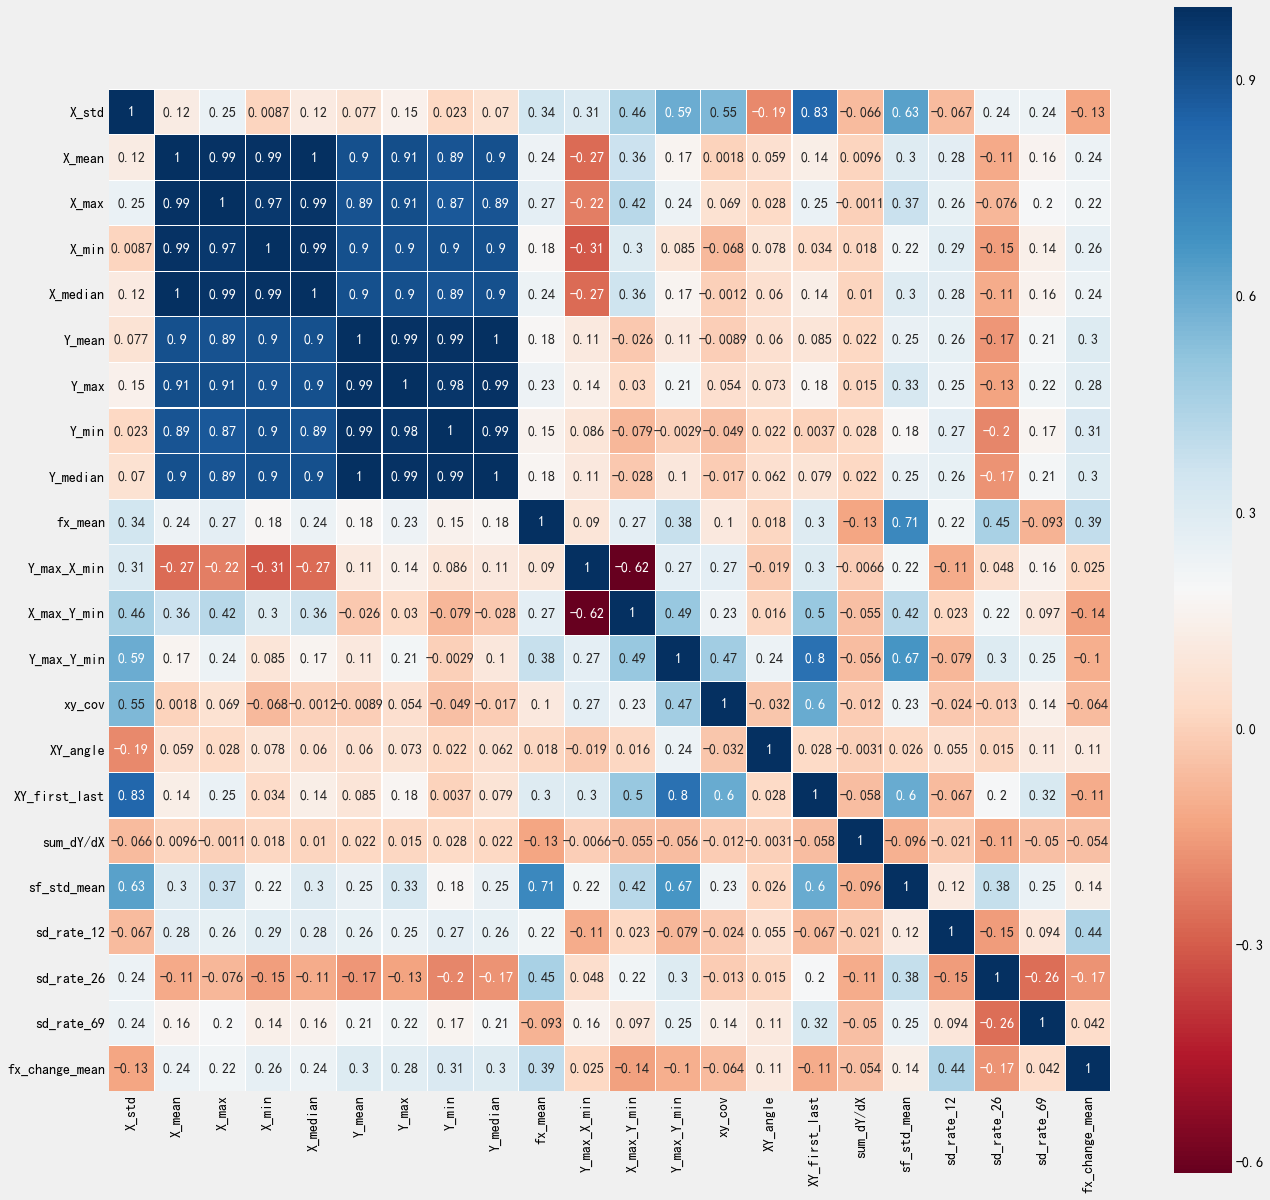

In [237]:
features_selected = col
# data_corr 
df_corr = df_train[col].copy()

colormap = plt.cm.RdBu
plt.figure(figsize=(20,20))
sns.heatmap(df_corr.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

In [11]:
folds = KFold(n_splits=5, shuffle=True, random_state=2020)
oof_lgb = np.zeros((len(df_train),3))
col = [tmp_col for tmp_col in df_train.columns if tmp_col not in ['label', 'filename','sd_min','fx_min','fx_max','fx_median','dX_90',
                                                                 'X_max_X_min','X_mean/max','Y_mean/max','XY_mean/max',
                                                                 'Y_std','sd_small_1','sd_skew','sd_max','work_sd','XY_space','sd_std',
                                                                  'fx_std','a','sd_mean','sd_median','X_std'
                                                                 ]]
X_train = df_train[col].values
y_train = df_train['label'].values
prediction = np.zeros((len(df_test),3))

In [14]:
param = {'num_leaves': 31,
#          'min_data_in_leaf': 30, 
         'objective':'multiclassova',
         'num_class':3,
         'learning_rate': 0.01,
#          "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
#          "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
#          "bagging_seed": 11,
#          "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
models = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 2000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    models.append(clf)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    prediction += clf.predict(df_test[col].values, num_iteration=clf.best_iteration)
#     oof_lgb2 += clf.predict(df_remove[col].values, num_iteration=clf.best_iteration)
oof_lgb_final = np.argmax(oof_lgb, axis=1)  
#     predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits



fold n°1
Training until validation scores don't improve for 100 rounds
[500]	training's multi_logloss: 0.145938	valid_1's multi_logloss: 0.268923
[1000]	training's multi_logloss: 0.0717912	valid_1's multi_logloss: 0.24369
[1500]	training's multi_logloss: 0.0392501	valid_1's multi_logloss: 0.237545
Early stopping, best iteration is:
[1518]	training's multi_logloss: 0.0384268	valid_1's multi_logloss: 0.237317
fold n°2
Training until validation scores don't improve for 100 rounds
[500]	training's multi_logloss: 0.145999	valid_1's multi_logloss: 0.249219
[1000]	training's multi_logloss: 0.070779	valid_1's multi_logloss: 0.225603
[1500]	training's multi_logloss: 0.0377306	valid_1's multi_logloss: 0.221634
Early stopping, best iteration is:
[1576]	training's multi_logloss: 0.0345744	valid_1's multi_logloss: 0.221323
fold n°3
Training until validation scores don't improve for 100 rounds
[500]	training's multi_logloss: 0.140883	valid_1's multi_logloss: 0.286221
[1000]	training's multi_logloss:

In [15]:
f1_score(y_train, oof_lgb_final, average='macro')



0.8966292287848013

In [233]:
ret = []
for index,model in enumerate(models):
    df = pd.DataFrame()
    df['name'] = col
    df['score'] = model.feature_importance()
    df['fold'] = index
    ret.append(df)

df = pd.concat(ret)

In [234]:
df = df.groupby('name', as_index=False)['score'].mean()
df


,name,score
0,XY_angle,5454.1
1,XY_first_last,4583.7
2,X_max,5073.5
3,X_max_Y_min,7155.5
4,X_mean,4166.1
5,X_median,6288.9
6,X_min,6723.3
7,X_std,5957.1
8,Y_max,7021.7
9,Y_max_X_min,9147.8


In [235]:
pred_label = np.argmax(prediction, axis=1)
label_dict = {0:'拖网', 1:'刺网', 2:'围网'}
df_pred = pd.DataFrame()
df_pred['filename'] = df_test['filename']
df_pred['label'] = pred_label
df_pred['label'] = df_pred['label'].map(label_dict)
df_pred.to_csv('sub2.csv', index=None, header=False)

